In [1]:
import numpy as np
try:  
    import cupy as xp  
    USE_GPU = True 
except ImportError:  
    import numpy as xp 
    print('No Cupy')
    USE_GPU = False 

import matplotlib.pyplot as plt
from tqdm import tqdm

# to mute the warnings of lal 
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import * 
from Triangle.GW import * 
from Triangle.TDI import * 

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

np.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Useful functions 

In [2]:
class GBToolkits: 
    @classmethod
    def frequency_band(cls, f0, Tobs, single_side_pad_frac=1./4.):
        """  
        Args: 
            f0: central frequency of the target band
            Tobs: total observation time 
            single_side_pad_band: the fraction to be padded at both sides 
        Returns: 
            the lower, upper limits of the frequency band, both before and after padding 
        """
        df_chirp = 2.542e-10 * (Tobs / YEAR) * (f0 / 1e-3) ** (11/3) # the const. factors are calculated based on the mass limit of WDs 
        df_doppler = 9.935e-8 * (f0 / 1e-3)
        fmin = f0 - df_doppler
        fmax = f0 + df_chirp + df_doppler
        pad_band = (fmax - fmin) * single_side_pad_frac
        fmin_pad = fmin - pad_band
        fmax_pad = fmax + pad_band
        return fmin, fmax, fmin_pad, fmax_pad

    @classmethod
    def frequency_derivative_range(cls, f0):
        """ 
            Calculate the frequency evolution caused by GW emission. 
            These expressions do not apply to DWDs with mass transfer, whose fdot may be negative. 
        """
        dfmin = 1.209e-9 * f0 ** (11/3) 
        dfmax = 8.055e-7 * f0 ** (11/3)
        return dfmin, dfmax

    @classmethod
    def get_fddot(cls, f, fdot):
        return 11.0 / 3.0 * fdot ** 2 / f

    @classmethod
    def Params2VecParams(cls, params):
        """  
            convert params of shape (9, Nevents) to (Nevents, 8)
            the original params are: A, f0, fdot, fddot, phase0, iota, psi, lambda, beta (to be passed to GBGPU)
            the converted params are: lgA, f0, fdot, phase0, cosiota, psi, lambda, sinbeta (to be passed to ERYN)
        """
        p = np.transpose(params.copy()) # (Nevents, Nparams=9)
        p[:, 0] = np.log10(p[:, 0]) # lgA
        p[:, 5] = np.cos(p[:, 5]) # cos iota 
        p[:, 8] = np.sin(p[:, 8]) # sin beta 
        ind_list = [0, 1, 2, 4, 5, 6, 7, 8] # remove fddot 
        return p[:, ind_list] # (Nevents, Nparams=8)

    @classmethod
    def VecParams2Params(cls, vecparams):
        """  
            convert params of shape (Nevents, 8) to (9, Nevents)
            the original params are: lgA, f0, fdot, phase0, cosiota, psi, lambda, sinbeta
            the converted params are: A, f0, fdot, fddot, phase0, iota, psi, lambda, beta
        """
        p = np.zeros((9, vecparams.shape[0])) # (Nparams=9, Nevents)
        p[0:3] = np.transpose(vecparams[:, 0:3])
        p[4:9] = np.transpose(vecparams[:, 3:8])
        p[0] = np.power(10, p[0]) # lgA to A 
        p[3] = cls.get_fddot(f=p[1], fdot=p[2]) # fddot 
        p[5] = np.arccos(p[5]) # cos iota to iota 
        p[8] = np.arcsin(p[8]) # sin beta to beta 
        return p # (Nparams=9, Nevents)

    @classmethod
    def loglikelihood(cls, vecparams, gb, dt, Tobs, data_channels, data_PSDs, df, cutinds, Npoints=1024):
        """  
        Args: 
            vecparmas: params of shape (Nevents, 8) 
            gb: an initialized GBGPU object (use_gpu should be True)
            dt: the sampling cadance in second 
            Tobs: total observation time in second 
            data_channels: frequency-domain data of shape (2, Nfreqs), 2 for AE
            data_PSDs: PSD of shape (2, Nfreqs)
            df: frequency resolution of data 
            cutinds: index of used data in the whole array of Fourier frequencies 
            Npoints: number of points calculated by GBGPU, usually 512 is enough for a several-year data  
        Returns: 
            vectorized log likelihood
        """
        # convert parameters 
        params = cls.VecParams2Params(vecparams=vecparams)
        
        # calculate waveforms
        gb.run_wave(*params, dt=dt, T=Tobs, N=Npoints, oversample=4, tdi2=True)
        
        # fill into templates
        Nevents = len(vecparams)
        wf_templates = xp.zeros((Nevents, 2, len(cutinds)), dtype=xp.complex128)
        gb.fill_global_template(group_index=xp.arange(Nevents), templates=wf_templates, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)
        
        # calculate likelihood array 
        if USE_GPU:
            return (-2. * df * xp.sum(xp.sum(xp.abs(wf_templates - data_channels) ** 2 / data_PSDs, axis=-1), axis=-1)).get()
        else: 
            return (-2. * df * xp.sum(xp.sum(xp.abs(wf_templates - data_channels) ** 2 / data_PSDs, axis=-1), axis=-1))

## Load TDC data and combine TDI channels 

In [3]:
# path of the TDC verification binary dataset 
h5filename = "/media/ps/One Touch/TDCII_Data/0_Verification_Dataset/data/VGB.h5" 
with h5py.File(h5filename, "r") as h5file: 
    data_dict = read_dict_from_h5(h5file["/"])
print("keys of raw data:", data_dict.keys())

# path of Taiji orbit 
orbitfilename = "/home/ps/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB" 

# calculate delays in preparation for tdi 
orbit_for_ltts = Orbit(OrbitDir=orbitfilename)
ltts = dict() 
for key in MOSA_labels: 
    ltts[key] = orbit_for_ltts.LTTfunctions()[key](data_dict["time"])
ltts = MOSADict(ltts)

# tdi combination. this might take a while.
m = {"eta" : data_dict["eta"]}
fsample = 1. / (data_dict["time"][1] - data_dict["time"][0])
tdi = TDI(measurements=m, delays=ltts, fsample=fsample, order=31) 
tdi.FastMichelson(channel="AET", doppler=True)

# drop the invalid points at the edges caused by delays 
channel_names = ["A2", "E2", "T2"]
drop_points = int(fsample * 1500.)
for channel_name in channel_names: 
    tdi.measurements[channel_name][:drop_points] *= 0. 
    tdi.measurements[channel_name][-drop_points:] *= 0. 

keys of raw data: dict_keys(['eta', 'time'])


In [9]:
# load vgb parameters 
h5paramfilename = "/media/ps/One Touch/TDCII_Data/0_Verification_Dataset/data/VGB_parameters.h5" 
with h5py.File(h5paramfilename, "r") as h5file: 
    vgb_parameters = read_dict_from_h5(h5file["/"])
vgb_parameters

{'A': array([4.25222560e-23, 9.40241544e-23, 1.22249337e-22, 9.38108004e-23,
        9.51718037e-23, 1.57720636e-22, 1.21831837e-22, 1.63225926e-22,
        5.32815192e-23, 2.80100838e-22, 9.92272693e-23, 6.47670162e-23,
        1.54980995e-22, 4.88354923e-22, 3.01443707e-22, 1.58751080e-22,
        1.23411018e-22, 1.73241130e-22, 1.93365124e-22, 1.35747496e-23,
        7.03054197e-23, 8.13586240e-23, 8.34987307e-23, 3.14016144e-23,
        2.07317172e-22, 3.63776299e-23, 7.17605446e-23, 3.58524032e-23,
        3.66149230e-23, 3.61651386e-23, 1.20942200e-22, 1.01062402e-22,
        7.62559124e-23, 1.38405020e-22, 1.35222162e-22, 1.04926795e-22,
        1.13446017e-22, 2.73934878e-22, 3.94029157e-22, 4.38871071e-22,
        3.36366429e-22, 4.32666841e-23, 2.80038746e-23, 4.96253179e-23,
        7.79602201e-23, 6.83936229e-23, 8.29173098e-23, 2.45233571e-23,
        4.12499307e-23, 4.91916954e-22, 2.54991626e-22, 1.83805143e-22,
        1.33443313e-22, 4.13536966e-22, 4.23719131e-22]),
 

## Plot frequency-domain data 
The high frequencies beyond GW source frequencies are dominated by readout noises and interpolation errors, thus a downsampling process is needed for better time-domain visualization. 
While this analysis will be done in frequency domain, so we neglect the downsampling step.

Text(0, 0.5, 'Fourier transofrm of data')

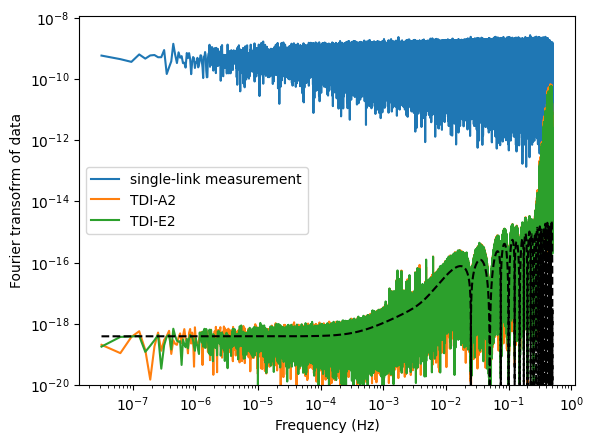

In [8]:
channel_names = ["A2", "E2"] # use AE only hereafter 

win_type = "tukey"
win_alpha = 0.05

# before tdi 
ff, xf = FFT_window(data_dict["eta"]["12"], fsample=fsample, window_type=win_type, window_args_dict=dict(alpha=win_alpha))
plt.loglog(ff, np.abs(xf), label="single-link measurement")

# after tdi 
for channel_name in channel_names: 
    ff, xf = FFT_window(tdi.measurements[channel_name], fsample=fsample, window_type=win_type, window_args_dict=dict(alpha=win_alpha))
    plt.loglog(ff, np.abs(xf), label="TDI-"+channel_name)

# Taiji noise requirement 
PSDfunc = TDIPSDs()
plt.loglog(ff, np.sqrt(PSDfunc.PSD_A2(ff) * data_dict["time"][-1] / 2.), linestyle="--", color='k')

plt.ylim(1e-20,)
# plt.xlim(1e-4, 0.1)

plt.legend(loc="center left")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier transofrm of data")

## select frequency band to analyze 

In [12]:
vgb_idx = 4 # select the 5th source as an example 

parameters = dict()
for k, v in vgb_parameters.items(): 
    parameters[k] = v[vgb_idx]

central_frequency = parameters["f0"]

parameters

{'A': 9.517180373037876e-23,
 'f0': 0.0032247077104776,
 'fdot0': 5.536765590227253e-17,
 'inclination': 1.0471975511965976,
 'latitude': -0.3548927927646199,
 'longitude': 0.4294914200344345,
 'phase0': 1.3208186729980294,
 'psi': 2.099368941065471}

In [ ]:
# set metadata 
dt = data_dict["time"][1] - data_dict["time"][0]
Tobs = data_dict["time"][-1] - data_dict["time"][0]
print('Tobs [day], dt [s]:', Tobs/DAY, dt)

# fourier transform  
data_channels = []
for i, k in enumerate(channel_names):
    ff, xff = FFT_window(
        tdi.measurements[k], 
        fsample, 
        window_type=win_type, 
        window_args_dict=dict(alpha=win_alpha)
        )
    data_channels.append(np.concatenate(([0.], xff))) # add a DC term to match the convension of xp.fft.rfft
data_channels = xp.array(data_channels)
data_frequency = xp.array(np.concatenate(([0.], ff)))

# remove data outside the frequency bin defined by the frequency evolution of signal, we use a similar binning to Phys.Rev.D 110 (2024) 2, 024005
fmin, fmax, fmin_pad, fmax_pad = GBToolkits.frequency_band(f0=central_frequency, Tobs=Tobs, single_side_pad_frac=0.5)
cutinds = xp.where((data_frequency <= fmax_pad)&(data_frequency >= fmin_pad))[0]
data_channels_cut = data_channels[:, cutinds]
data_frequency_cut = data_frequency[cutinds]
df = data_frequency_cut[1] - data_frequency_cut[0]

print("df [Hz], data shape:", df, data_channels_cut.shape)

Tobs [day], dt [s]: 365.25635416666665 1.0
df [Hz], data shape: 3.168753655346038e-08 (2, 41)


### estimate noise PSD

In [14]:
# calculate PSD using the left and right intervals where there are no signals 
f_interval = fmax_pad - fmin_pad 
f_leftmin = fmin_pad - f_interval
f_leftmax = fmin_pad
f_rightmin = fmax_pad 
f_rightmax = fmax_pad + f_interval 
ind_psd_left = xp.where((data_frequency >= f_leftmin)&(data_frequency <= f_leftmax))[0]
ind_psd_right = xp.where((data_frequency >= f_rightmin)&(data_frequency <= f_rightmax))[0]
ind_psd_tot = xp.concatenate((ind_psd_left, ind_psd_right))
mean_psd_A = xp.mean(xp.abs(data_channels[0][ind_psd_tot]) ** 2 * 2. / Tobs) # calculate PSD with periodgram 
mean_psd_E = xp.mean(xp.abs(data_channels[1][ind_psd_tot]) ** 2 * 2. / Tobs) 
data_PSDs_cut = xp.ones_like(data_channels_cut, dtype=xp.float64) # model PSDs as constants since the frequency bin is relatively small 
data_PSDs_cut[0] *= mean_psd_A
data_PSDs_cut[1] *= mean_psd_E
print("estimated ASDs:", np.sqrt(mean_psd_A), np.sqrt(mean_psd_E))

estimated ASDs: 1.010239450968007e-21 9.884605878505627e-22


Text(0, 0.5, 'Fourier-domain waveform')

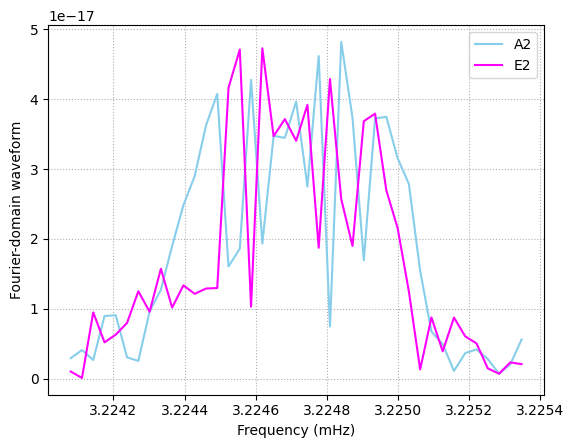

In [17]:
channel_colors = ["skyblue", "magenta"]
for i, (channel_name, channel_color) in enumerate(zip(channel_names, channel_colors)):
    if USE_GPU:
        plt.plot(data_frequency_cut.get() * 1e3, np.abs(data_channels_cut[i].get()), label=channel_name, color=channel_color)
    else: 
        plt.plot(data_frequency_cut * 1e3, np.abs(data_channels_cut[i]), label=channel_name, color=channel_color)
plt.legend(loc="upper right")
plt.grid(linestyle=':')
plt.xlabel("Frequency (mHz)")
plt.ylabel("Fourier-domain waveform")

## Initialize GB model by modified GBGPU

In [18]:
from gbgpu.gbgpu import GBGPU
from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

/home/ps/.local/lib/python3.9/site-packages/gbgpu-0.1-py3.9-linux-x86_64.egg/gbgpu/gbgpu.py:25: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/home/ps/.local/lib/python3.9/site-packages/gbgpu-0.1-py3.9-linux-x86_64.egg/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


In [19]:
Npoints = 512

gb = GBGPU(
    use_gpu=USE_GPU, 
    orbit_file=orbitfilename,
    unequal_arm=True,
    )

## Test waveform modeling with the fiducial parameters 

In [20]:
# manipulate parameters
amp = parameters['A']  # amplitude
f0 = parameters['f0']  # f0
fdot = parameters['fdot0']  # fdot
fddot = GBToolkits.get_fddot(f=f0, fdot=fdot)
phi0 = parameters['phase0']  # initial phase
iota = parameters['inclination']  # inclination
psi = parameters['psi']  # polarization angle
lam = parameters['longitude']  # ecliptic longitude
beta_sky = parameters['latitude']  # ecliptic latitude

amp_in = np.atleast_1d(amp)
f0_in = np.atleast_1d(f0)
fdot_in = np.atleast_1d(fdot)
fddot_in = np.atleast_1d(fddot)
phi0_in = np.atleast_1d(phi0)
iota_in = np.atleast_1d(iota)
psi_in = np.atleast_1d(psi)
lam_in = np.atleast_1d(lam)
beta_sky_in = np.atleast_1d(beta_sky)

params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

vecparams = GBToolkits.Params2VecParams(params)
print("fiducial parameters:", vecparams)

# calculate waveforms 
gb.run_wave(*params, N=Npoints, dt=dt, T=Tobs, oversample=4, tdi2=True)

# fill into the fourier templates compatible with  data 
wf_templates = xp.zeros((1, 2, len(cutinds)), dtype=xp.complex128)
gb.fill_global_template(group_index=xp.array([0,]), templates=wf_templates, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)

fiducial parameters: [[-2.20214917e+01  3.22470771e-03  5.53676559e-17  1.32081867e+00
   5.00000000e-01  2.09936894e+00  4.29491420e-01 -3.47489841e-01]]


Text(0, 0.5, 'Fourier-domain waveform')

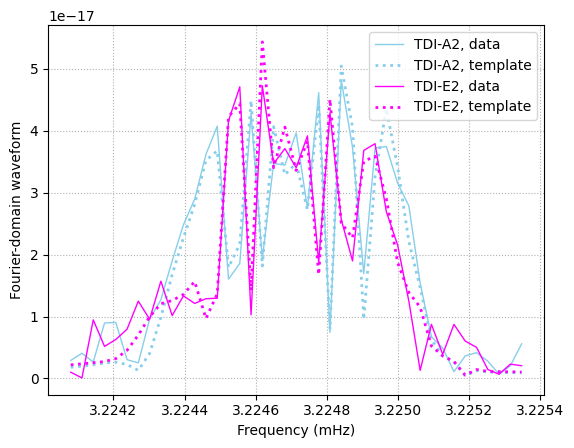

In [22]:
for i, (channel_name, channel_color) in enumerate(zip(channel_names, channel_colors)): 
    if USE_GPU:
        plt.plot(data_frequency_cut.get() * 1e3, np.abs(data_channels_cut[i].get()), label='TDI-'+channel_name+', data', color=channel_color, alpha=1, linewidth=1)
        plt.plot(data_frequency_cut.get() * 1e3, np.abs(wf_templates[0][i].get()), label='TDI-'+channel_name+', template', color=channel_color, linestyle=':', linewidth=2)
    else: 
        plt.plot(data_frequency_cut * 1e3, np.abs(data_channels_cut[i]), label='TDI-'+channel_name+', data', color=channel_color, alpha=1, linewidth=1)
        plt.plot(data_frequency_cut * 1e3, np.abs(wf_templates[0][i]), label='TDI-'+channel_name+', template', color=channel_color, linestyle=':', linewidth=2)

plt.legend(loc="upper right")
plt.grid(linestyle=':')
plt.xlabel("Frequency (mHz)")
plt.ylabel("Fourier-domain waveform")

## Test likelihood around the true values 
This is only a test for the waveform and likelihood.  
The peak value of loglikelihood would not be at the truth since the data is noisy. 

Text(0, 0.5, 'log likelihood')

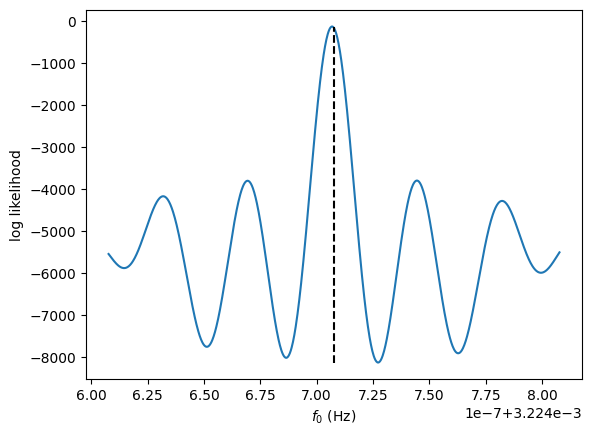

In [23]:
# test the freuqnecy parameter 
test_n = 1001
test_freqs = np.linspace(-1e-7, 1e-7, test_n) + vecparams[0][1]
test_vecparams = np.zeros((test_n, vecparams.shape[1]))
for i in range(test_n):
    test_vecparams[i] = vecparams.copy()
    test_vecparams[i][1] = test_freqs[i]
test_ll = GBToolkits.loglikelihood(test_vecparams, gb, dt, Tobs, data_channels_cut, data_PSDs_cut, df, cutinds, Npoints)

plt.plot(test_freqs, test_ll)
plt.vlines(vecparams[0][1], min(test_ll), max(test_ll), color='k', linestyle='--')
plt.xlabel(r'$f_0$'+' (Hz)')
plt.ylabel('log likelihood')

## Run MCMC

In [32]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

import corner

In [33]:
# hyper parameters
ndim = 8
nwalkers = 200
ntemps = 10
if ntemps == 1:
    temps = np.array([1.])
else:
    temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty])
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

# priors
# These priors are rather conservative. Hopefully they can be better constrained by some astrophysical reasons? 
lim_lgA = [-24, -20] # a relatively broad range
lim_f0 = np.array([fmin, fmax]) # only the unpadded range 
lim_df0 = np.array([-1e-15, 1e-15]) # a relatively broad range 
lim_phi0 = [0, TWOPI] 
lim_cosinc = [-1, 1] 
lim_psi = [0, PI]
lim_lam = [0, TWOPI] 
lim_sinbeta = [-1, 1]

lims = [lim_lgA, lim_f0, lim_df0, lim_phi0, lim_cosinc, lim_psi, lim_lam, lim_sinbeta]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

In [34]:
# set emcee move 
Emceemoves = StretchMove(a=2) # 2 by default
stop = None 

# # initialize sampler 
# init_ensemble = EnsembleSampler(
#     nwalkers,
#     ndim,
#     GBToolkits.loglikelihood,
#     priors,
#     args=[gb, dt, Tobs, data_channels_cut, data_PSDs_cut, df, cutinds, Npoints],
#     tempering_kwargs=tempering_kwargs,
#     stopping_fn=None,
#     moves=Emceemoves,
#     vectorize=True,
# )

# # set backend file 
# chain_filename='./Chains/MCMC_'+str(vgb_idx)+'.h5'
# backend = HDFBackend(chain_filename)
# backend.reset(nwalkers=nwalkers, ndims=ndim, ntemps=ntemps, moves=init_ensemble.backend.move_keys)
# print('args of the backend =', backend.reset_args)
# print('move keys =', backend.move_keys)
# print('Initialization flag of backend =', backend.initialized)


ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    GBToolkits.loglikelihood,
    priors,
    args=[gb, dt, Tobs, data_channels_cut, data_PSDs_cut, df, cutinds, Npoints],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=None,
    moves=Emceemoves,
    # backend=backend,
    vectorize=True,
)

In [35]:
# starting positions
# randomize throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))
print("shape of starting points:", coords.shape)

thin_by =100
burn = 0
nsteps = int(100000 / thin_by)

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

shape of starting points: (10, 200, 8)


100%|██████████| 100000/100000 [24:47<00:00, 67.21it/s]


### resume run if necessary 

In [36]:
# # ensemble.stopping_fn = None
# thin_by =100
# burn = 0
# nsteps = int(100000 / thin_by)

# out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

## Monitor MCMC run 

In [40]:
param_labels = [r'${\rm lg}A$', r'$f_0$', r'$\dot{f}_0$', r'$\varphi_0$', r'$\cos \iota$', r'$\psi$', r'$\lambda$', r'$\sin \beta$']
param_truths = vecparams[0]
param_truths

array([-2.20214917e+01,  3.22470771e-03,  5.53676559e-17,  1.32081867e+00,
        5.00000000e-01,  2.09936894e+00,  4.29491420e-01, -3.47489841e-01])

In [41]:
samples = ensemble.get_chain(discard=0, thin=1)
raw_sample = samples['model_0'][:, :, :, 0, :]
nstep = raw_sample.shape[0]
ntemp = raw_sample.shape[1]
nwalker = raw_sample.shape[2]
ndim = raw_sample.shape[3]

raw_sample = None
print(nstep, ntemp, nwalker, ndim)

1000 10 200 8


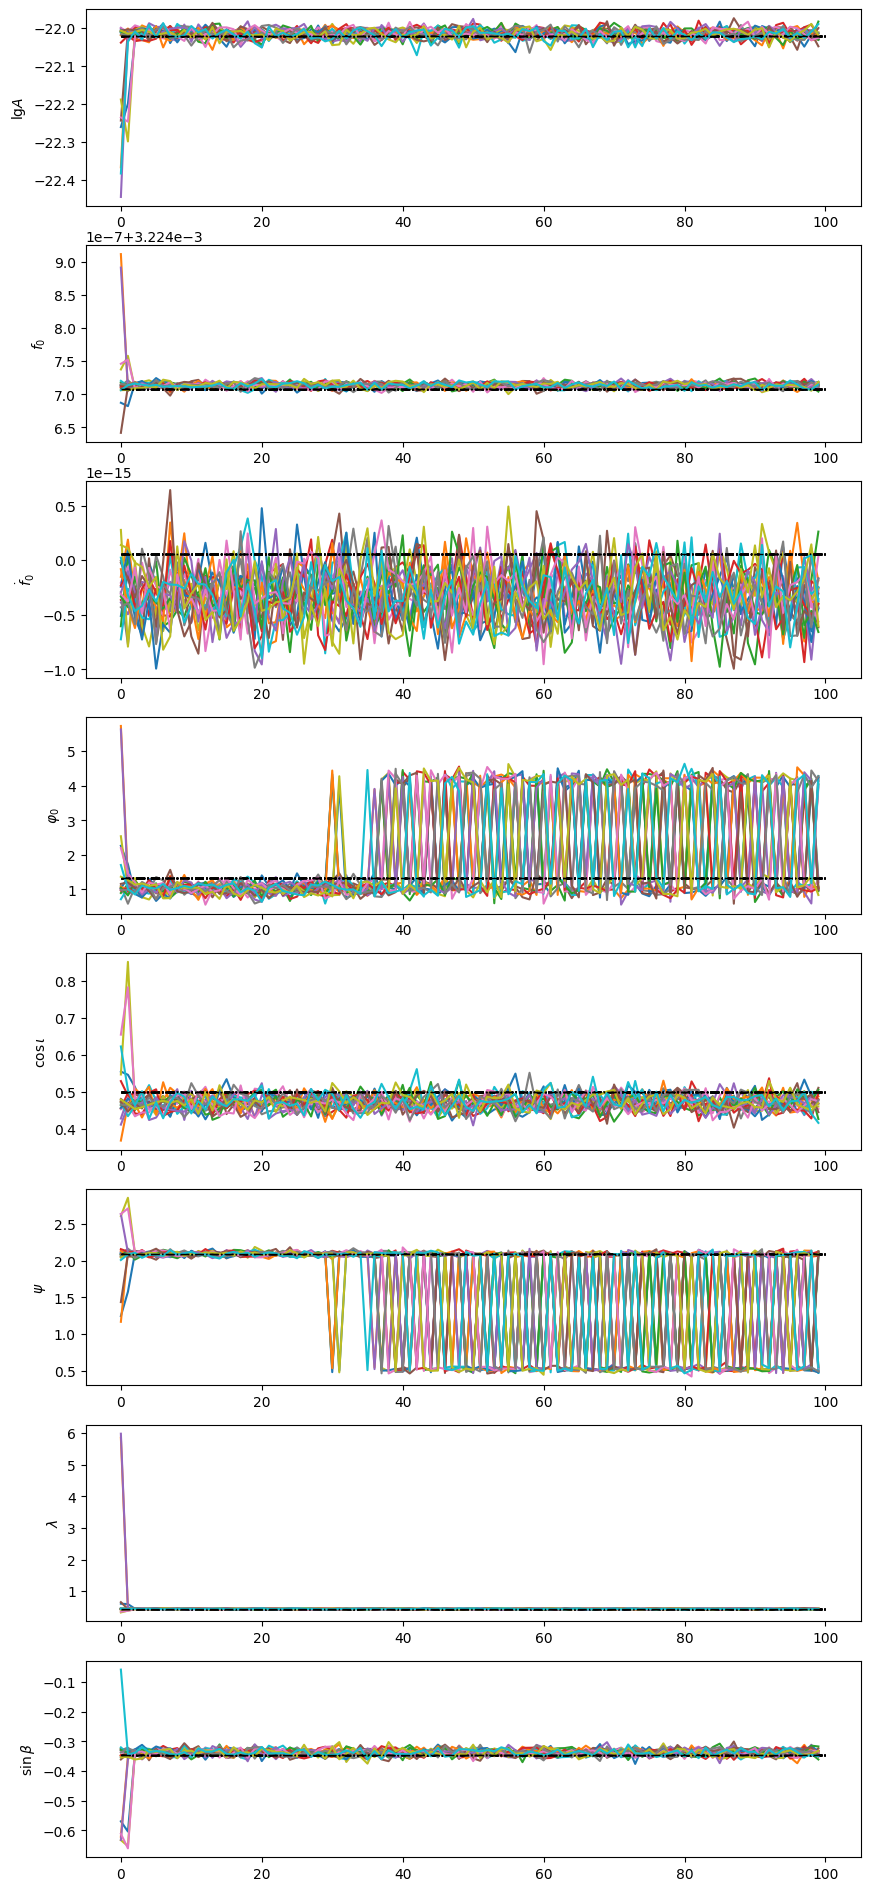

In [42]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):
    for walk in range(20):
    # for walk in range(nwalker):
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(param_truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=1)
    ax[i].set_ylabel(param_labels[i])

## Plot posterior 

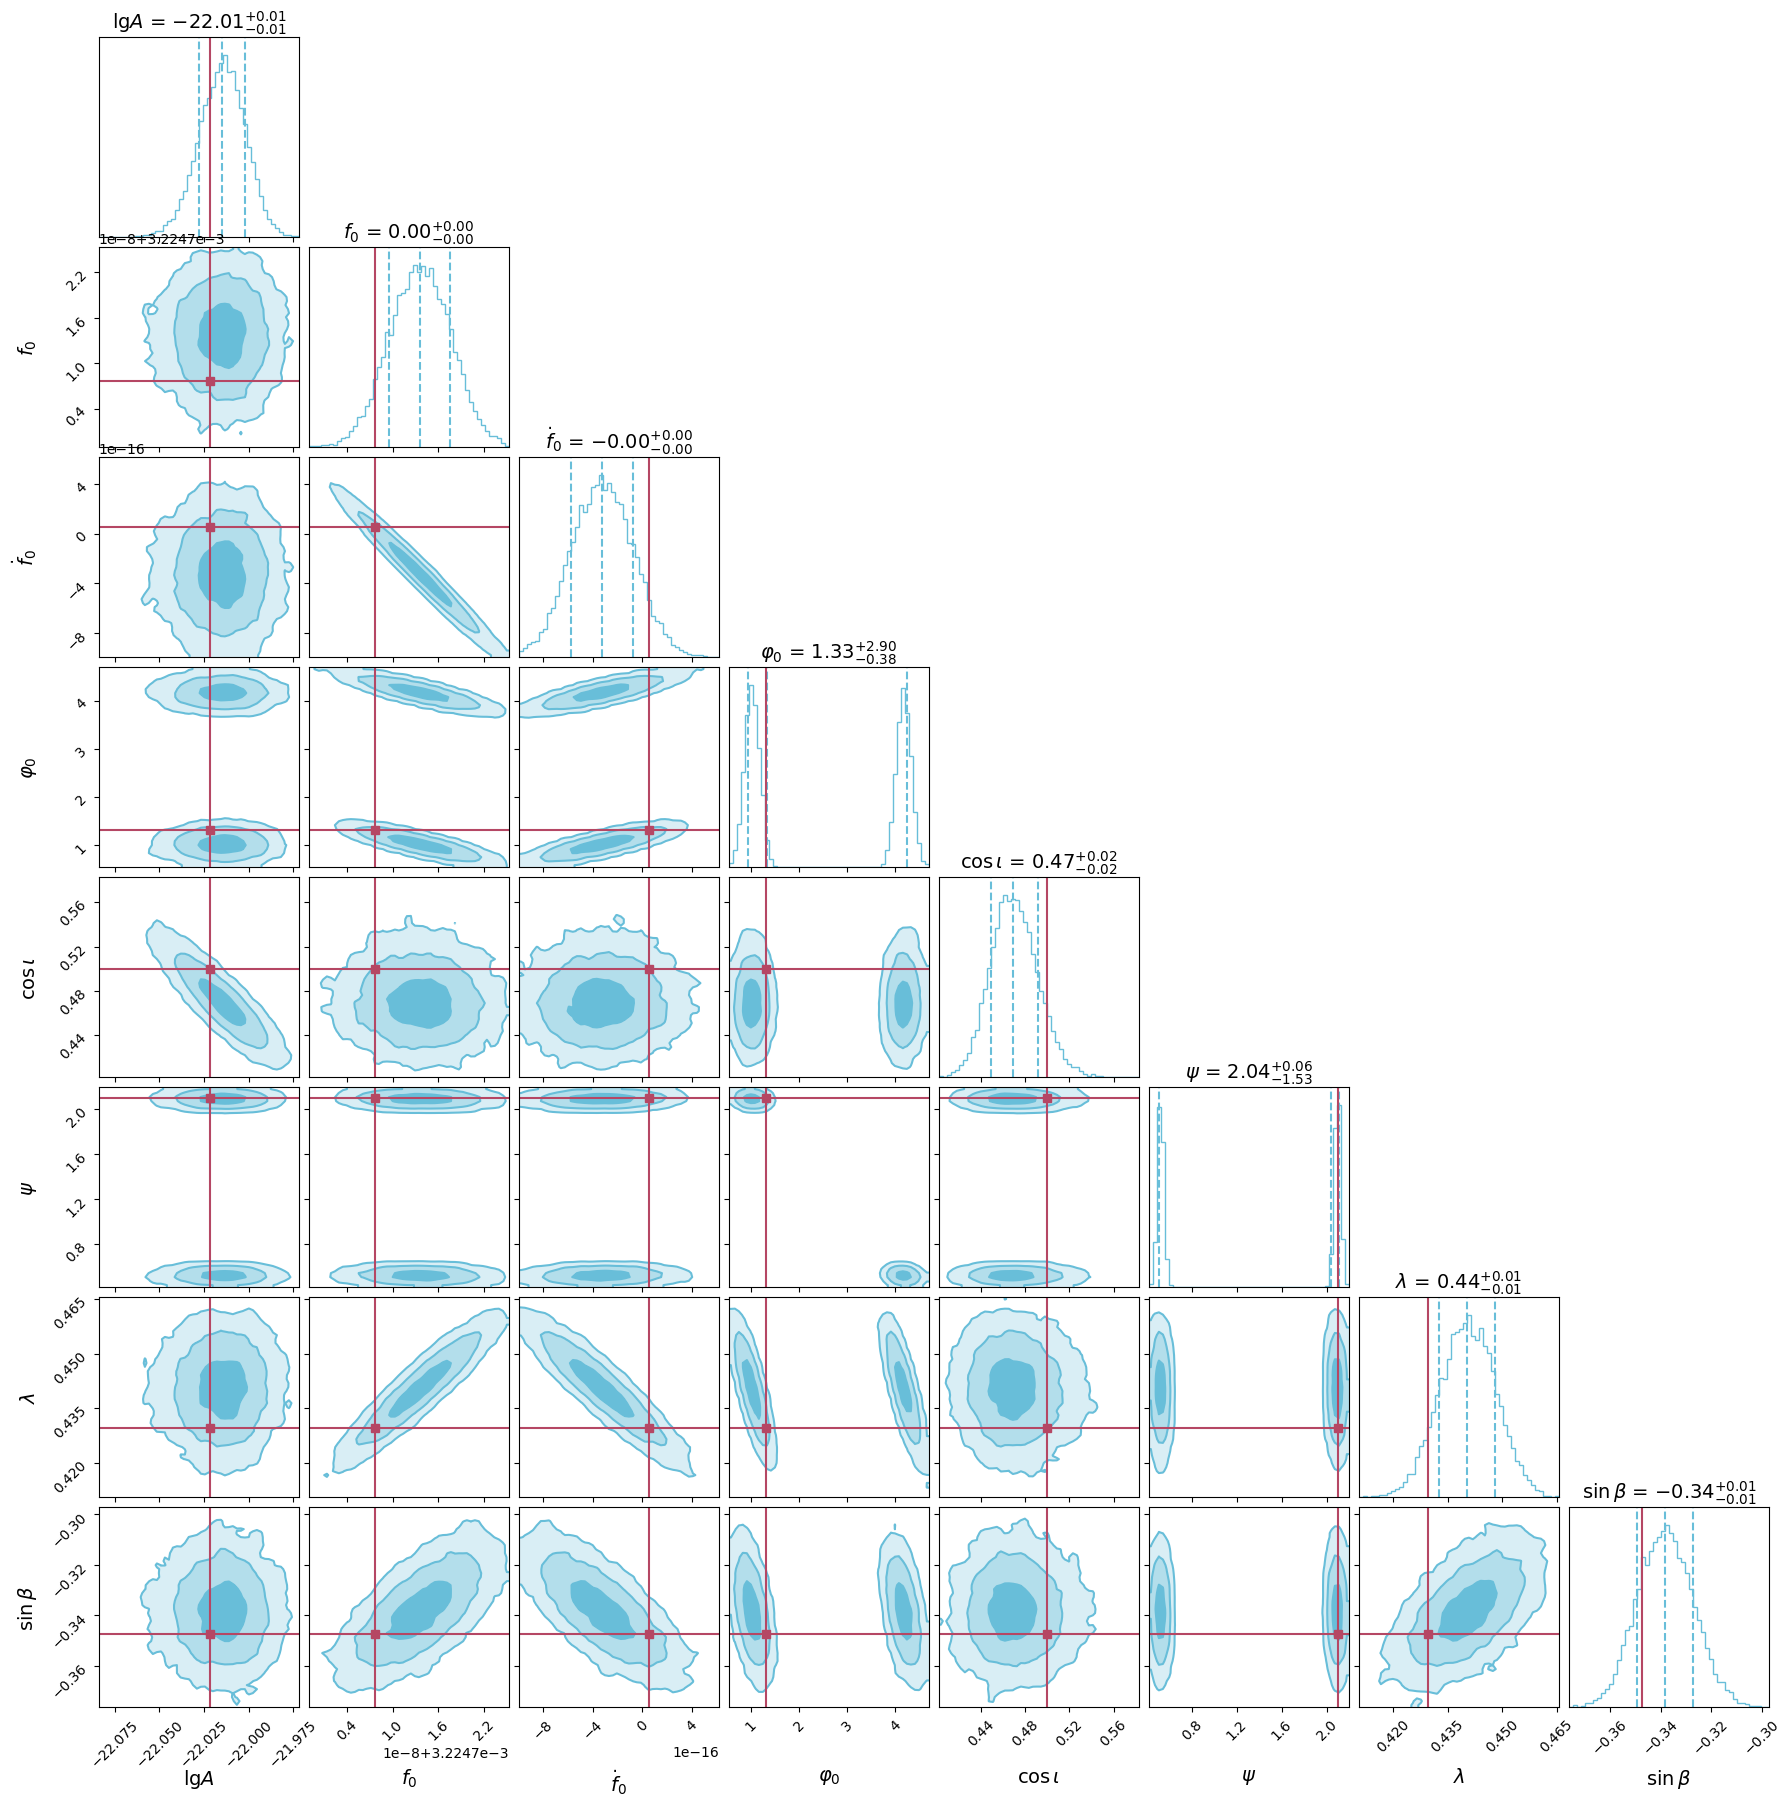

In [44]:
burnin=400 # set according to the chains
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)

masks = [True for _ in param_labels]
# masks[3] = False
# masks[2] = False
# masks[6] = False

figure = corner.corner(
    samp[:, masks], bins=50, color=BLUE, 
    # range = lims, # comment this line to plot smaller ranges
    labels=np.array(param_labels)[masks], label_kwargs={'fontsize': 14}, 
    truths=np.array(param_truths)[masks], truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)), # 3-sigmas
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
np.save("chain_VGB"+str(vgb_idx)+".npy", samp)
plt.savefig("posterior_VGB"+str(vgb_idx)+".jpg", dpi=360)